# March Madness Round of 64 k-NN Algorithm

## Introduction

The purpose of this project is to develop an effective method for predicting Round of 64 outcomes in the NCAA Division I March Madness Basketball Tournament.  We will implement a k-Nearest Neighbors ML algorithm on data from Kenpom and FiveThirtyEight.

## The Data

**Kenpom**: advanced team statistic data was taken from kenpom.com for the 2014-2019 seasons  
**FiveThirtyEight**: tournament outcome data were taken from fivethirtyeight.com for the 2014-2019 NCAA Tournaments

## Imports

In [158]:
import glob

import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## KenPom data

In [159]:
# this cell loads each season's .csv file to respective 'kenpom' variable name
years = np.arange(14, 20)

kp_list = []
for x in years:
    x = "kenpom" + str(x)
    kp_list.append(x)
    
var_list = tuple(zip(kp_list, years))

for var in var_list:
    globals()[var[0]] = pd.read_csv("summary" + str(var[1]) + "_pt.csv")

In [160]:
import sqlalchemy

# connect to database system
# pd.read_sql takes in a parameter for a SQLite engine, which we create below
sqlite_uri = "sqlite:///marchmadness.db"
sqlite_engine = sqlalchemy.create_engine(sqlite_uri)

In [161]:
# start with an empty database - DROP the tables if they
# already exist in the database (from a previous run)
sql_expr = """
DROP TABLE IF EXISTS kenpom14;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom15;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom16;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom17;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom18;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom19;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom_all;
"""
result = sqlite_engine.execute(sql_expr)

In [162]:
# populate kenpom SQL tables
for var in var_list:
    globals()[var[0]] = globals()[var[0]].to_sql("kenpom" + str(var[1]), con = sqlite_engine)

In [163]:
# concatenate all kenpom seasons into same table
# create 'Relative AdjEM' variable that quantifies team's strength relative to best team in country
sql_expr = """
SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom14) AS RelativeAdjEM
FROM kenpom14

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom15) AS RelativeAdjEM
FROM kenpom15

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom16) AS RelativeAdjEM
FROM kenpom16

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom17) AS RelativeAdjEM
FROM kenpom17

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom18) AS RelativeAdjEM
FROM kenpom18

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom19) AS RelativeAdjEM
FROM kenpom19
"""

kenpom_all = pd.read_sql(sql_expr, sqlite_engine)
kenpom_all = kenpom_all.to_sql('kenpom_all', con = sqlite_engine)

In [164]:
# drop irrelevant columns
sql_expr = """
SELECT
    Season,
    TeamName AS Team,
    seed,
    AdjEM,
    RankAdjEM,
    RelativeAdjEM,
    AdjTempo,
    RankAdjTempo,
    AdjOE,
    RankAdjOE,
    AdjDE,
    RankAdjDE
FROM kenpom_all
WHERE NOT seed = 'NaN'
ORDER BY
    Season,
    seed,
    AdjEM DESC
"""

kenpom = pd.read_sql(sql_expr, sqlite_engine)

In [165]:
kenpom['Team'] = kenpom['Team'].astype('string')
kenpom

,Season,Team,seed,AdjEM,RankAdjEM,RelativeAdjEM,AdjTempo,RankAdjTempo,AdjOE,RankAdjOE,AdjDE,RankAdjDE
0,2014,Arizona,1.0,30.39640,2,0.994396,63.1175,267,115.1930,24,84.7964,1
1,2014,Florida,1.0,27.81060,3,0.909803,61.5519,317,116.2160,18,88.4056,4
2,2014,Virginia,1.0,26.42850,4,0.864589,59.6528,345,113.8500,31,87.4218,2
3,2014,Wichita St.,1.0,25.18040,8,0.823758,63.5718,245,117.1170,15,91.9370,11
4,2014,Kansas,2.0,25.40110,5,0.830978,66.8907,78,119.9740,6,94.5731,27
...,...,...,...,...,...,...,...,...,...,...,...,...
403,2019,Iona,16.0,-3.07828,197,-0.086335,70.5217,45,106.5140,132,109.5930,275
404,2019,North Dakota St.,16.0,-3.19855,199,-0.089708,64.7859,312,106.5520,127,109.7510,278
405,2019,Fairleigh Dickinson,16.0,-4.24870,208,-0.119161,66.7742,214,106.1840,137,110.4320,295
406,2019,Prairie View A&M,16.0,-4.30871,209,-0.120844,70.9610,34,101.5300,226,105.8380,205


## FiveThirtyEight Data

In [166]:
five38_file_extension = 'FiveThirtyEight.csv'
five38_filenames = [i for i in glob.glob(f"*{five38_file_extension}")]

In [167]:
combined_538_data = pd.DataFrame()
for file in five38_filenames:
    tourney = pd.read_csv(file)
    tourney.insert(0, 'Season', pd.to_numeric(file[0:4]))
    combined_538_data = pd.concat([combined_538_data, tourney])

In [168]:
fivethirtyeight = combined_538_data.drop(columns = ['team_alive', 'team_region', 'playin_flag', 
                                                    'rd1_win', 'timestamp', 'win_odds', 'team_id',
                                                    'gender', 'forecast_date', 'results_to', 'team_slot']) \
                                   .rename(columns = {'team_name': 'Team',
                                                      'team_seed': 'Seed',
                                                      'rd2_win': 'P(R32)',
                                                      'rd3_win': 'P(S16)', 
                                                      'rd4_win': 'P(E8)', 
                                                      'rd5_win': 'P(F4)', 
                                                      'rd6_win': 'P(Finals)', 
                                                      'rd7_win': 'P(Champion)'})

fivethirtyeight['Seed'] = fivethirtyeight['Seed'].astype('string')
fivethirtyeight['Seed'] = pd.to_numeric(fivethirtyeight['Seed'].str.replace('[a-z]+', ''))
fivethirtyeight['Team'] = fivethirtyeight['Team'].astype('string')
fivethirtyeight

,Season,Team,finish,Seed,P(R32),P(S16),P(E8),P(F4),P(Finals),P(Champion),team_rating
0,2014,Albany,1,16,0.012296,0.002051,0.000283,0.000032,0.000004,3.948740e-07,NaN
1,2014,American,1,15,0.071595,0.020689,0.003560,0.000373,0.000047,7.626705e-06,NaN
2,2014,Arizona,4,1,0.977695,0.726877,0.582110,0.423917,0.230737,1.335146e-01,NaN
3,2014,Arizona St.,1,10,0.498813,0.124986,0.031258,0.005652,0.001842,6.024659e-04,NaN
4,2014,Baylor,3,6,0.703237,0.338103,0.143483,0.044268,0.017873,8.000559e-03,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59,2019,Virginia Tech,3,4,0.888466,0.617061,0.187704,0.102977,0.044954,1.977161e-02,89.26
60,2019,Washington,2,9,0.494005,0.065142,0.020543,0.006295,0.001581,4.003935e-04,82.55
61,2019,Wisconsin,1,5,0.600614,0.330329,0.088254,0.037996,0.018056,7.172178e-03,86.54
62,2019,Wofford,2,7,0.633499,0.185530,0.078656,0.025003,0.007437,2.204709e-03,84.38


## Merge Dataframes

In [169]:
# merge kenpom and fivethirtyeight data
teams = kenpom.merge(fivethirtyeight, on = ['Season', 'Team'])
teams = teams.drop(columns = ['seed'])

## Clean Data

### Create dummy variable for Round of 64 outcome

In [170]:
# make binary variable to denote if team advanced to 2nd Round (R32) or not
finishes = []
for finish in teams.finish:
    if finish > 1:
        finish = 2
        finishes.append(finish)
    else:
        finishes.append(finish)
teams.finish = finishes

### Select relevant variables

In [171]:
teams = teams[['Season', 'Team', 'AdjOE', 'AdjDE', 'finish']]
teams

,Season,Team,AdjOE,AdjDE,finish
0,2014,Arizona,115.193,84.7964,2
1,2014,Florida,116.216,88.4056,2
2,2014,Virginia,113.850,87.4218,2
3,2014,Wichita St.,117.117,91.9370,2
4,2014,Kansas,119.974,94.5731,2
...,...,...,...,...,...
379,2019,Bradley,100.892,101.2500,1
380,2019,Gardner Webb,107.475,108.2180,1
381,2019,Iona,106.514,109.5930,1
382,2019,North Dakota St.,106.552,109.7510,1


In [184]:
np.mean(teams['AdjOE'])

112.76550078125001

In [185]:
np.mean(teams['AdjDE'])

97.24276223958333

## Construct k-NN Algorithm for Classifying March Madness Round of 64 Outcome

### 2 Features
- **AdjOE**: points scored per 100 offensive possessions adjusted for the quality of opposing defenses, the site of each game, and when each game was played
- **AdjDE**: points allowed per 100 offensive possessions adjusted for the quality of opposing defenses, the site of each game, and when each game was played

### Feature Scaling

In [172]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x, ddof = 1)

# convert features to standard units so they
# hold equal weight in distance to neighbors
teams = teams[['AdjOE', 'AdjDE', 'finish']]
teams_std = pd.DataFrame(
         {"AdjOE": standard_units(teams.AdjOE),
          "AdjDE": standard_units(teams.AdjDE),
          "finish": teams.finish})

### Split data into training and validation sets (80/20 split)

In [173]:
np.random.seed(3)

# number of rows in df
num_rows = teams.shape[0]

# number of rows put into testing data
# 20% of entire dataset
per_fold = (num_rows // 5) + 1

# shuffle rows of teams df
teams_std = teams_std.sample(frac = 1)

# create validation set for out of sample testing
# 20% of entire dataset
validation_fold = teams_std[-per_fold:]

# remove testing data from df
# 80% of entire dataset
training_fold = teams_std[:-per_fold]

# separate predictors from outcome variable
training_X = np.asarray(training_fold.drop(columns = ['finish']))
training_Y = np.asarray(training_fold['finish'])

In [174]:
# create dict to store test score for each k parameter
# initialize neigh_dict to be all zeros
neigh_dict = {}
for k in np.arange(1, 40, 2):
    neigh_dict[k] = 0

# tune k parameter with leave-one-out cross-validation
# (only odd values to break ties)
cv = LeaveOneOut()
for k in np.arange(1, 40, 2):
    knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    # leave-one-out cross validation
    score = round(np.mean(cross_val_score(knn, training_X, training_Y, cv = cv)), 4)
    neigh_dict[k] += score

# return average test score for each k parameter
print('k-NN Test Accuracies:')
for k, v in neigh_dict.items():
    print(k, ": ", v)

# find optimal k parameter
optimal_k = max(neigh_dict, key = neigh_dict.get)
print('\n')
print("optimal k: ", optimal_k)

# Test k-NN model performance on (unseen) validation data
# separate predictors from outcome variable in validation fold
validation_x = np.asarray(validation_fold.drop(columns = ['finish']))
validation_y = np.asarray(validation_fold['finish'])

# return score of k-NN algorithm on validation fold with optimal k parameter
knn = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute')
fit = knn.fit(training_X, training_Y)
val_preds = fit.predict(validation_x)
accuracy = accuracy_score(validation_y, val_preds)
print('Validation Accuracy:', round(accuracy, 4))

k-NN Test Accuracies:
1 :  0.7068
3 :  0.759
5 :  0.772
7 :  0.772
9 :  0.7362
11 :  0.7394
13 :  0.7459
15 :  0.7394
17 :  0.7459
19 :  0.7362
21 :  0.7362
23 :  0.7524
25 :  0.7557
27 :  0.7622
29 :  0.7622
31 :  0.7557
33 :  0.7655
35 :  0.759
37 :  0.759
39 :  0.7459


optimal k:  5
Validation Accuracy: 0.6364


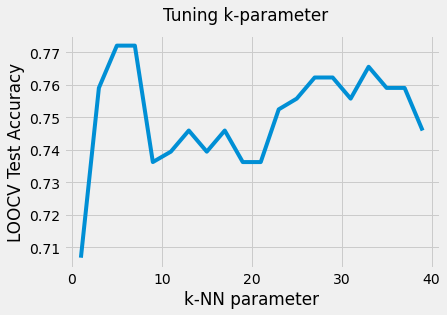

In [175]:
lists = sorted(neigh_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plots.plot(x, y)
plots.suptitle('Tuning k-parameter')
plots.xlabel('k-NN parameter')
plots.ylabel('LOOCV Test Accuracy');
plots.show()

k = 5 and k = 7 have the best testing accuracy (77.2%) with Leave-One-Out Cross-Validation. Let's examine the decision boundary at k = 5...

## Visualize k-NN Decision Boundary

### Fit Final Model (k = 5)

In [176]:
final_X = np.asarray(teams.drop(columns = ['finish']))
final_Y = np.asarray(teams['finish'])

knn = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute')
fit = knn.fit(final_X, final_Y)

### Create Grid

In [177]:
# for visualization - construct a grid of potential points for classifying

# create arrays spanning the range of values of features
x_array = []
y_array = []
for x in np.arange(95, 130.1, 0.25):
    for y in np.arange(80, 115.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

# create grid
test_grid = pd.DataFrame(
        {"AdjOE": x_array,
         "AdjDE": y_array})  

# predict outcome across entire grid
grid_preds = knn.predict(test_grid)

### Visualize k = 5 Decision Boundary

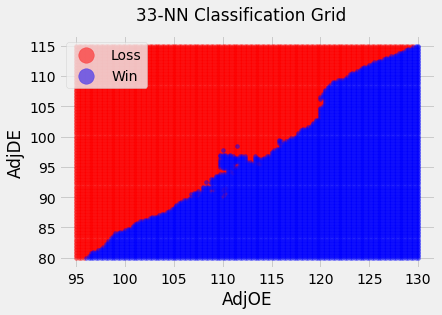

In [233]:
# a visualization of the k-NN classification grid

# k-NN algorithm
plots.scatter(test_grid.AdjOE[grid_preds == 1], test_grid.AdjDE[grid_preds == 1], 
              color = 'red', alpha = 0.5, s = 15,
              label = 'Loss')
plots.scatter(test_grid.AdjOE[grid_preds == 2], test_grid.AdjDE[grid_preds == 2], 
              color = 'blue', alpha = 0.5, s = 15,
              label = 'Win')

plots.suptitle(str(optimal_k) + '-NN Classification Grid')
plots.legend(loc = "upper left", markerscale = 4)
plots.xlabel('AdjOE')
plots.ylabel('AdjDE');

Further investigation reveals that the decision boundary at low k values is not as smooth as desired.  Lower AdjDE is better and higher AdjOE is better.  Thus, it does not make sense to have many stray pockets of different classes in the decision boundary diagram.  These pockets at lower k values could be due to randomness from a smaller sample size.  By increasing the k-parameter, we can smooth the decision boundary.

The next best choice for k is k = 33.  Let's examine the decision boundary for the new parameter...

## Update Model with New k-Parameter (k = 33)

### Fit Updated Final Model

In [179]:
optimal_k = 33

knn = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute')
fit = knn.fit(final_X, final_Y)

### Update Grid Predictions

In [180]:
# predict outcome across entire grid
grid_preds = knn.predict(test_grid)

### Visualize k = 33 Decision Boundary

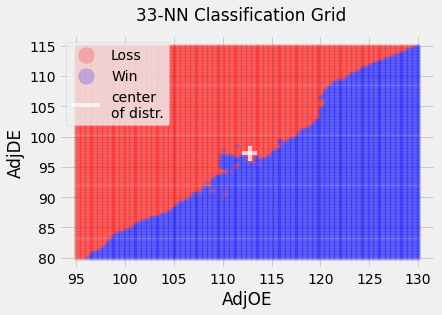

In [234]:
# a visualization of the k-NN classification grid

# k-NN algorithm
plots.scatter(test_grid.AdjOE[grid_preds == 1], test_grid.AdjDE[grid_preds == 1], 
              color = 'red', alpha = 0.2, s = 15,
              label = 'Loss')
plots.scatter(test_grid.AdjOE[grid_preds == 2], test_grid.AdjDE[grid_preds == 2], 
              color = 'blue', alpha = 0.2, s = 15,
              label = 'Win')

# center of distribution
plots.vlines(np.mean(teams['AdjOE']), ymin = 96, ymax = 98.5, 
             color = 'white', alpha = 0.7, label = 'center\nof distr.')
plots.hlines(np.mean(teams['AdjDE']), xmin = 112, xmax = 113.5, 
             color = 'white', alpha = 0.7)

plots.suptitle(str(optimal_k) + '-NN Classification Grid')
plots.legend(loc = "upper left", markerscale = 4)
plots.xlabel('AdjOE')
plots.ylabel('AdjDE');

The decision boundary at k = 33 is smoother and makes much more sense than the previous model at k = 5.  The blue pocket in the center of the graph is an interesting phenomenon, as it juts out from the otherwise smooth red/blue boundary.  

This pocket is located near the center of the distribution of March Madness teams, which suggests that teams with balance between offense and defense may have an advantage in the Round of 64 of the NCAA Tournament.

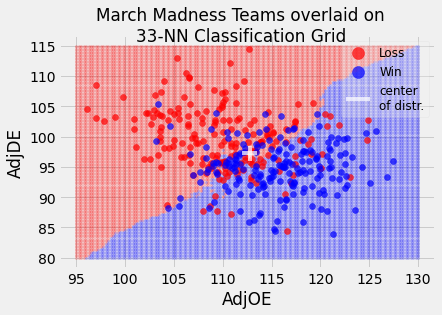

In [235]:
# a visualization of the k-NN classification grid (shaded in background), 
# with the entire dataset overlaid on top

# k-NN grid
plots.scatter(test_grid.AdjOE[grid_preds == 1], test_grid.AdjDE[grid_preds == 1], 
              color = 'red', alpha = 0.2, s = 5)
plots.scatter(test_grid.AdjOE[grid_preds == 2], test_grid.AdjDE[grid_preds == 2], 
              color = 'blue', alpha = 0.2, s = 5)

# teams data
plots.scatter(teams[teams.finish == 1]['AdjOE'], teams[teams.finish == 1]['AdjDE'],
              color = "red", label = "Loss", alpha = 0.7)
plots.scatter(teams[teams.finish == 2]['AdjOE'], teams[teams.finish == 2]['AdjDE'],
              color = "blue", label = "Win", alpha = 0.7)

# center of distribution
plots.vlines(np.mean(teams['AdjOE']), ymin = 96, ymax = 98.5, 
             color = 'white', alpha = 0.7, label = 'center\nof distr.')
plots.hlines(np.mean(teams['AdjDE']), xmin = 112, xmax = 113.5, 
             color = 'white', alpha = 0.7)

#plots.scatter(teams['AdjOE'], teams['AdjDE'], color = 'black')

plots.suptitle('March Madness Teams overlaid on\n' + str(optimal_k) + '-NN Classification Grid')
plots.legend(loc = "upper right", markerscale = 2, framealpha = 0.3, fontsize = 12)
plots.xlabel('AdjOE')
plots.ylabel('AdjDE');